In [1]:
"""
高频因子模型定价能力研究 - 代码实现+随机数值验证
复现论文: The pricing ability of factor model based on machine learning (2025)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [2]:
np.random.seed(42)

print("="*70)
print(" "*15 + "高频因子模型研究 - 开始运行")
print("="*70)

               高频因子模型研究 - 开始运行


In [3]:
# Part 1: 数据生成
print("\n[Step 1] 生成高频数据...")

def generate_high_frequency_data(n_stocks=200, n_days=100, intervals_per_day=48):
    """生成模拟的高频股票收益率数据"""
    M = n_days * intervals_per_day
    N = n_stocks

    print(f"  生成 {M} 个时间点 × {N} 只股票")

    # 生成3个real factor
    factor1 = np.random.normal(0, 0.002, M)
    factor2 = np.random.normal(0, 0.0008, M)
    factor3 = np.random.normal(0, 0.0005, M)

    # add日内效应
    for day in range(n_days):
        start = day * intervals_per_day
        factor1[start:start+6] *= 1.5  # 开盘
        factor1[start+42:start+48] *= 1.3  # 收盘

    factors = np.column_stack([factor1, factor2, factor3])

    # 生成因子载荷
    loadings = np.random.randn(N, 3)
    loadings[:, 0] = np.random.uniform(0.8, 1.2, N)
    loadings[:, 1] = np.random.normal(0, 0.5, N)
    loadings[:, 2] = np.random.normal(0, 0.3, N)

    # 生成return
    returns = factors @ loadings.T + np.random.normal(0, 0.001, (M, N))

    returns_df = pd.DataFrame(returns, columns=[f'Stock_{i+1}' for i in range(N)])

    print(f"完成 | 平均收益率: {returns.mean():.6f} | 波动率: {returns.std():.6f}")

    return returns_df, factors, loadings

returns_df, true_factors, true_loadings = generate_high_frequency_data()



[Step 1] 生成高频数据...
  生成 4800 个时间点 × 200 只股票
完成 | 平均收益率: 0.000008 | 波动率: 0.002470



[Step 2] 数据探索可视化...


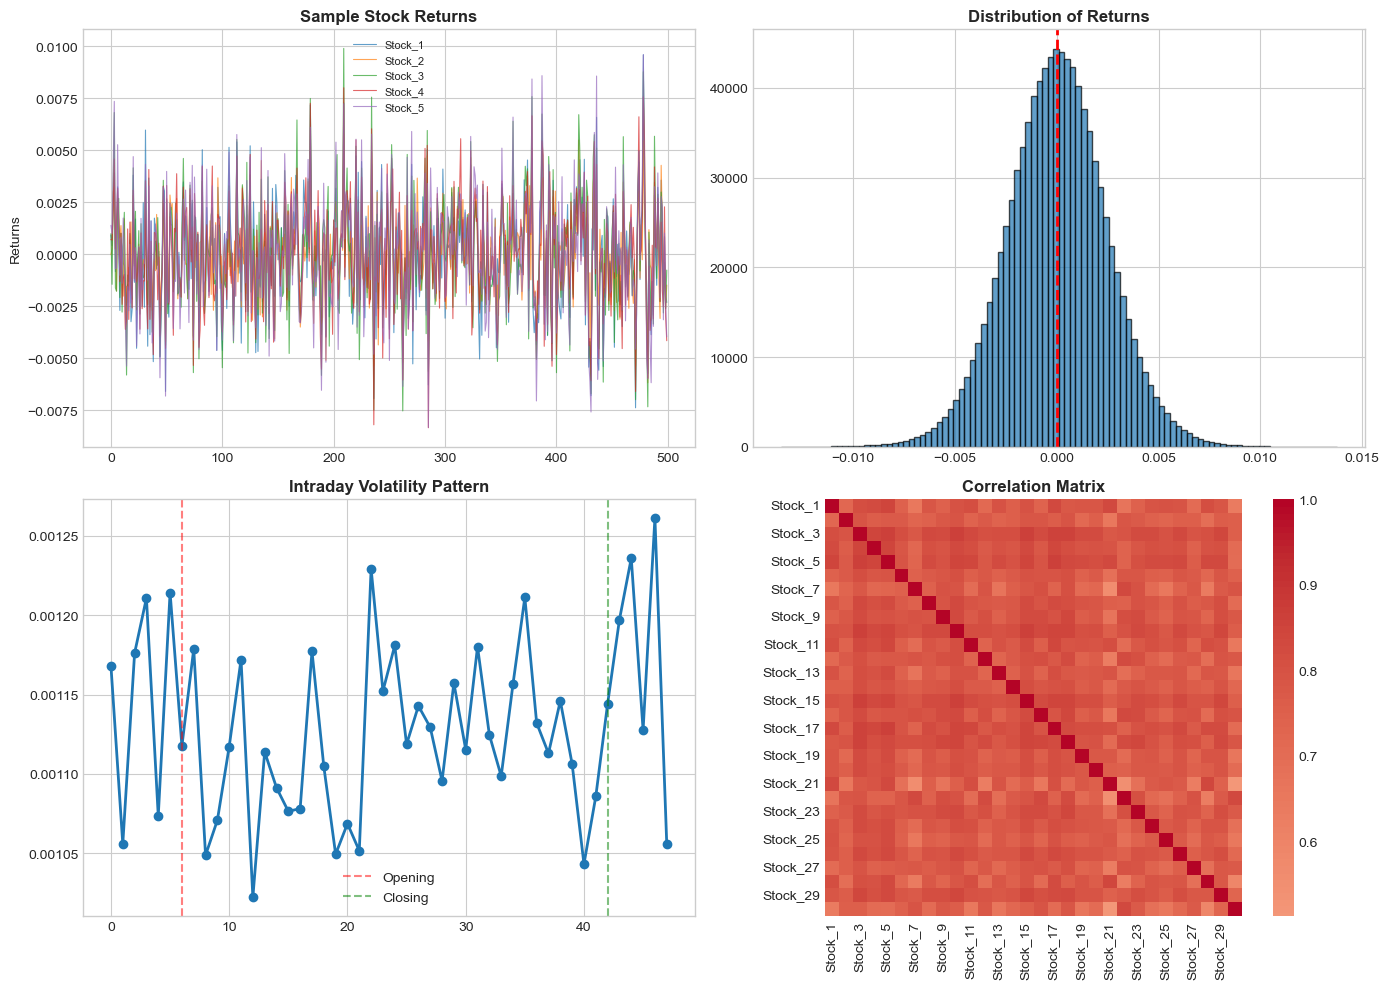

  ✓ 数据探索完成


In [23]:
  # Part 2: 数据可视化
# ============================================================================
print("\n[Step 2] 数据探索可视化...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 收益率时间序列
returns_df.iloc[:, :5].iloc[:500].plot(ax=axes[0, 0], alpha=0.7, linewidth=0.8)
axes[0, 0].set_title('Sample Stock Returns', fontweight='bold')
axes[0, 0].set_ylabel('Returns')
axes[0, 0].legend(fontsize=8)

# 2. 收益率分布
axes[0, 1].hist(returns_df.values.flatten(), bins=100, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Returns', fontweight='bold')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)

# 3. 日内波动
intraday_vol = []
for day in range(5):
    day_data = returns_df.iloc[day*48:(day+1)*48]
    intraday_vol.append(day_data.std(axis=1).values)

axes[1, 0].plot(range(48), np.mean(intraday_vol, axis=0), marker='o', linewidth=2)
axes[1, 0].set_title('Intraday Volatility Pattern', fontweight='bold')
axes[1, 0].axvline(6, color='red', linestyle='--', alpha=0.5, label='Opening')
axes[1, 0].axvline(42, color='green', linestyle='--', alpha=0.5, label='Closing')
axes[1, 0].legend()

# 4. 相关性
corr = returns_df.iloc[:, :30].corr()
sns.heatmap(corr, cmap='coolwarm', center=0, ax=axes[1, 1], square=True)
axes[1, 1].set_title('Correlation Matrix', fontweight='bold')

plt.tight_layout()
plt.show()

print("  ✓ 数据探索完成")

In [24]:
# Part 3: PCA提取高频因子
print("\n[Step 3] 提取高频统计因子...")

def extract_hf_factors(returns, n_components=6):
    """使用PCA提取高频统计因子"""
    M, N = returns.shape

    # 协方差矩阵特征值分解
    cov_matrix = (1/N) * (returns.T @ returns)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # 降序排列
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # 计算载荷和因子
    loadings = eigenvectors[:, :n_components] * np.sqrt(N)
    Lambda_T_Lambda = loadings.T @ loadings
    factors = returns @ loadings @ np.linalg.inv(Lambda_T_Lambda)

    # 解释方差
    explained_var_ratio = eigenvalues[:n_components] / eigenvalues.sum()

    print(f"提取 {n_components} 个因子")
    print(f"累计解释方差: {explained_var_ratio.sum():.4f}")

    return factors, loadings, eigenvalues, explained_var_ratio

estimated_factors, estimated_loadings, eigenvalues, exp_var_ratio = extract_hf_factors(returns_df.values)

# 显示解释比例
print("\n  各因子解释方差:")
for i in range(min(6, len(exp_var_ratio))):
    print(f"    Factor {i+1}: {exp_var_ratio[i]:.4f} ({exp_var_ratio[i]*100:.2f}%)")


[Step 3] 提取高频统计因子...
提取 6 个因子
累计解释方差: 0.8420

  各因子解释方差:
    Factor 1: 0.8026 (80.26%)
    Factor 2: 0.0317 (3.17%)
    Factor 3: 0.0043 (0.43%)
    Factor 4: 0.0012 (0.12%)
    Factor 5: 0.0012 (0.12%)
    Factor 6: 0.0011 (0.11%)



[Step 4] 因子提取结果可视化...


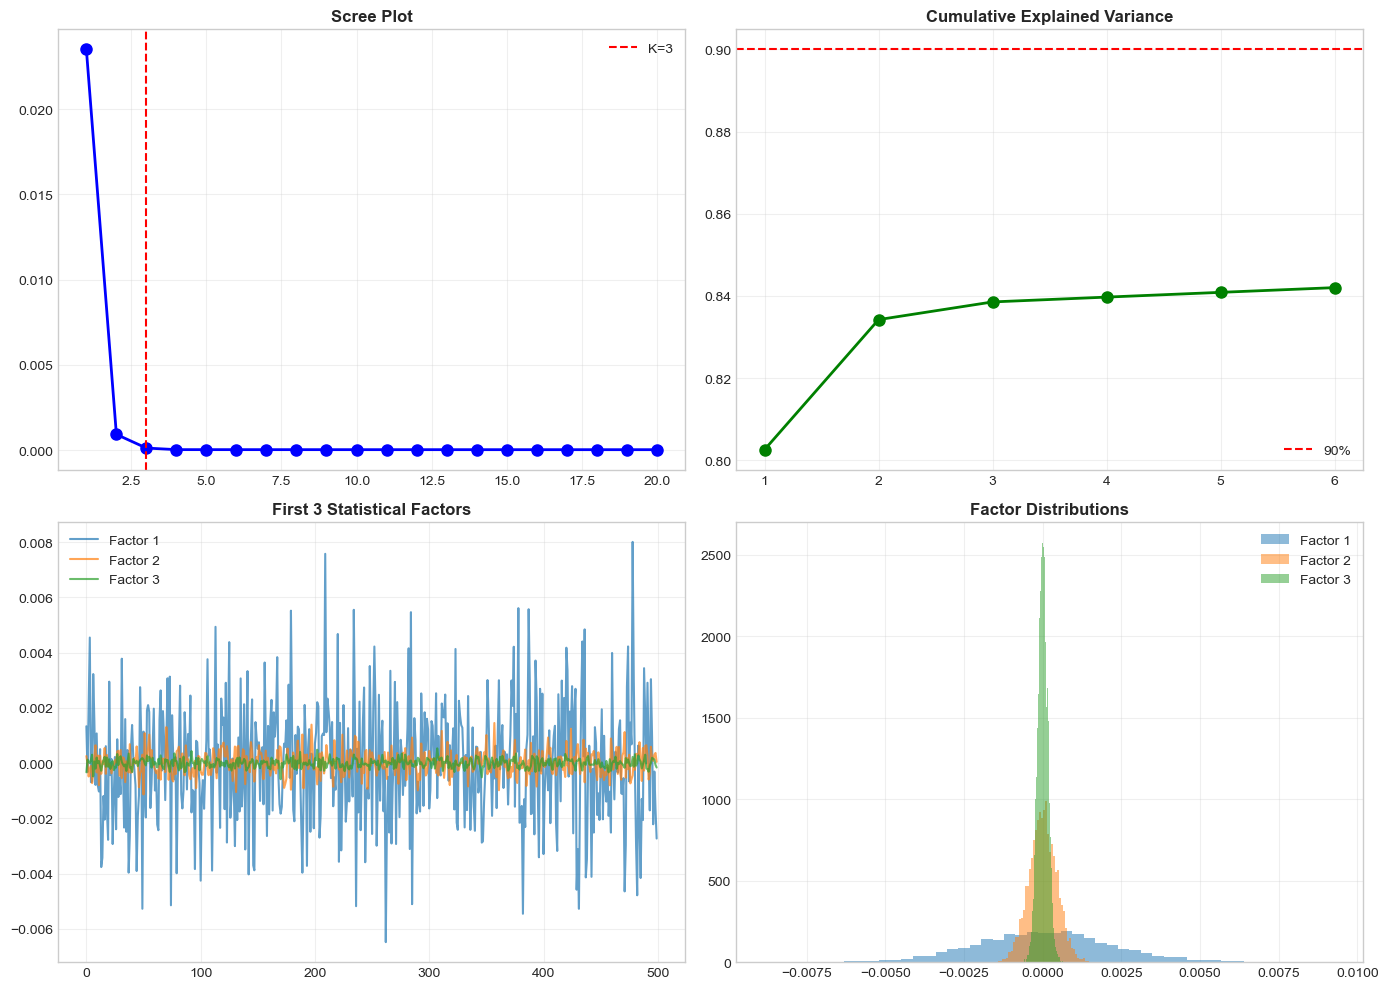

In [30]:
# Part 4: factor提取可视化
print("\n[Step 4] 因子提取结果可视化...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 碎石图
axes[0, 0].plot(range(1, 21), eigenvalues[:20], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_title('Scree Plot', fontweight='bold')
axes[0, 0].axvline(3, color='red', linestyle='--', label='K=3')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
# 2. 累计解释方差
cumsum_var = np.cumsum(exp_var_ratio)
axes[0, 1].plot(range(1, 7), cumsum_var, 'go-', linewidth=2, markersize=8)
axes[0, 1].axhline(0.9, color='red', linestyle='--', label='90%')
axes[0, 1].set_title('Cumulative Explained Variance', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. f时间序列
for k in range(3):
    axes[1, 0].plot(estimated_factors[:500, k], label=f'Factor {k+1}', alpha=0.7)
axes[1, 0].set_title('First 3 Statistical Factors', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. factor分布
for k in range(3):
    axes[1, 1].hist(estimated_factors[:, k], bins=50, alpha=0.5, label=f'Factor {k+1}', density=True)
axes[1, 1].set_title('Factor Distributions', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#finish f visiable



[Step 5] 扰动特征值比法确定因子数量...
最优因子数量: K = 3


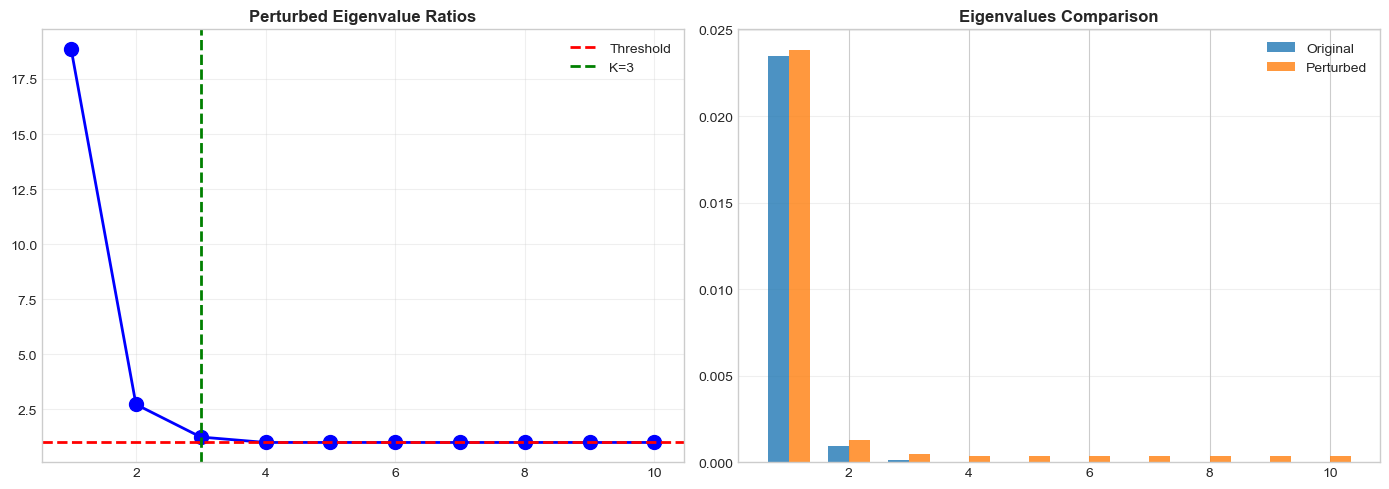

因子数量选择完成


In [13]:
# Part 5: 扰动特征值比法选择因子数量
print("\n[Step 5] 扰动特征值比法确定因子数量...")

def select_number_of_factors(eigenvalues, N, M, gamma=0.035):
    """使用扰动特征值比方法选择因子数量"""
    g = np.sqrt(N) * np.median(eigenvalues)
    perturbed_eig = eigenvalues + g
    ratios = perturbed_eig[:-1] / perturbed_eig[1:]

    threshold = 1 + gamma
    k_star = 0
    for k in range(min(10, len(ratios))):
        if ratios[k] > threshold:
            k_star = k + 1
        else:
            break

    return k_star, ratios[:10], perturbed_eig[:10]

N, M = returns_df.shape[1], returns_df.shape[0]
optimal_k, ratios, perturbed_eig = select_number_of_factors(eigenvalues, N, M)

print(f"最优因子数量: K = {optimal_k}")

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(1, 11)
axes[0].plot(x, ratios, 'bo-', linewidth=2, markersize=10)
axes[0].axhline(1.035, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[0].axvline(optimal_k, color='green', linestyle='--', linewidth=2, label=f'K={optimal_k}')
axes[0].set_title('Perturbed Eigenvalue Ratios', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

width = 0.35
axes[1].bar(x - width/2, eigenvalues[:10], width, label='Original', alpha=0.8)
axes[1].bar(x + width/2, perturbed_eig, width, label='Perturbed', alpha=0.8)
axes[1].set_title('Eigenvalues Comparison', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("因子数量选择完成")


In [29]:
# Part 6: 构建传统因子模型
print("\n[Step 6] 构建传统因子模型...")

def create_traditional_factors(returns):
    """创建CAPM和FF3因子"""
    M, N = returns.shape

    # 市场f
    market_factor = returns.mean(axis=1).reshape(-1, 1)

    # 规模f
    volatilities = returns.std(axis=0)
    n_half = N // 2
    small_stocks = np.argsort(volatilities)[:n_half]
    big_stocks = np.argsort(volatilities)[n_half:]
    smb = (returns[:, small_stocks].mean(axis=1) - returns[:, big_stocks].mean(axis=1)).reshape(-1, 1)

    # value factor
    mean_returns = returns.mean(axis=0)
    value_stocks = np.argsort(mean_returns)[:n_half]
    growth_stocks = np.argsort(mean_returns)[n_half:]
    hml = (returns[:, value_stocks].mean(axis=1) - returns[:, growth_stocks].mean(axis=1)).reshape(-1, 1)

    capm_factors = market_factor
    ff3_factors = np.hstack([market_factor, smb, hml])

    return capm_factors, ff3_factors

capm_factors, ff3_factors = create_traditional_factors(returns_df.values)

print(f"CAPM因子: {capm_factors.shape}")
print(f"FF3因子: {ff3_factors.shape}")
print(capm_factors)


[Step 6] 构建传统因子模型...
CAPM因子: (4800, 1)
FF3因子: (4800, 3)
[[ 0.00131725]
 [-0.00032601]
 [ 0.00204035]
 ...
 [-0.00514992]
 [-0.00540397]
 [ 0.00179729]]


In [15]:
# Part 7: 模型比较
print("\n[Step 7] 模型性能比较...")

def calculate_r_squared(returns, factors):
    """计算R²"""
    M, N = returns.shape
    r2_list = []

    for i in range(min(N, 100)):
        y = returns[:, i]
        X = np.column_stack([np.ones(M), factors])

        try:
            beta = np.linalg.lstsq(X, y, rcond=None)[0]
            y_pred = X @ beta
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - y.mean()) ** 2)
            if ss_tot > 1e-10:
                r2_list.append(1 - ss_res / ss_tot)
        except:
            continue

    return np.mean(r2_list)

def calculate_sharpe_ratio(factors):
    """计算Sharpe比率"""
    if len(factors.shape) == 1:
        factors = factors.reshape(-1, 1)

    sharpe_ratios = []
    for k in range(factors.shape[1]):
        mean_ret = factors[:, k].mean()
        std_ret = factors[:, k].std()
        if std_ret > 1e-10:
            sharpe_ratios.append((mean_ret / std_ret) * np.sqrt(4800))

    return max(sharpe_ratios) if sharpe_ratios else 0

# 计算各模型指标
results = {}

print("  [1/3] HF统计因子模型...")
r2_hf = calculate_r_squared(returns_df.values, estimated_factors[:, :3])
sharpe_hf = calculate_sharpe_ratio(estimated_factors[:, :3])
results['HF Statistical'] = {'R²': r2_hf, 'Sharpe': sharpe_hf}

print("  [2/3] CAPM模型...")
r2_capm = calculate_r_squared(returns_df.values, capm_factors)
sharpe_capm = calculate_sharpe_ratio(capm_factors)
results['CAPM'] = {'R²': r2_capm, 'Sharpe': sharpe_capm}

print("  [3/3] FF3模型...")
r2_ff3 = calculate_r_squared(returns_df.values, ff3_factors)
sharpe_ff3 = calculate_sharpe_ratio(ff3_factors)
results['FF3'] = {'R²': r2_ff3, 'Sharpe': sharpe_ff3}

results_df = pd.DataFrame(results).T
results_df['ΔR² vs CAPM'] = results_df['R²'] - results_df.loc['CAPM', 'R²']

print("\n" + "="*60)
print("模型比较结果:")
print("="*60)
print(results_df.round(4))


[Step 7] 模型性能比较...
  [1/3] HF统计因子模型...
  [2/3] CAPM模型...
  [3/3] FF3模型...

模型比较结果:
                    R²  Sharpe  ΔR² vs CAPM
HF Statistical  0.8288  0.2440       0.0330
CAPM            0.7958  0.2458       0.0000
FF3             0.8120  0.2458       0.0162



[Step 8] 模型比较可视化...


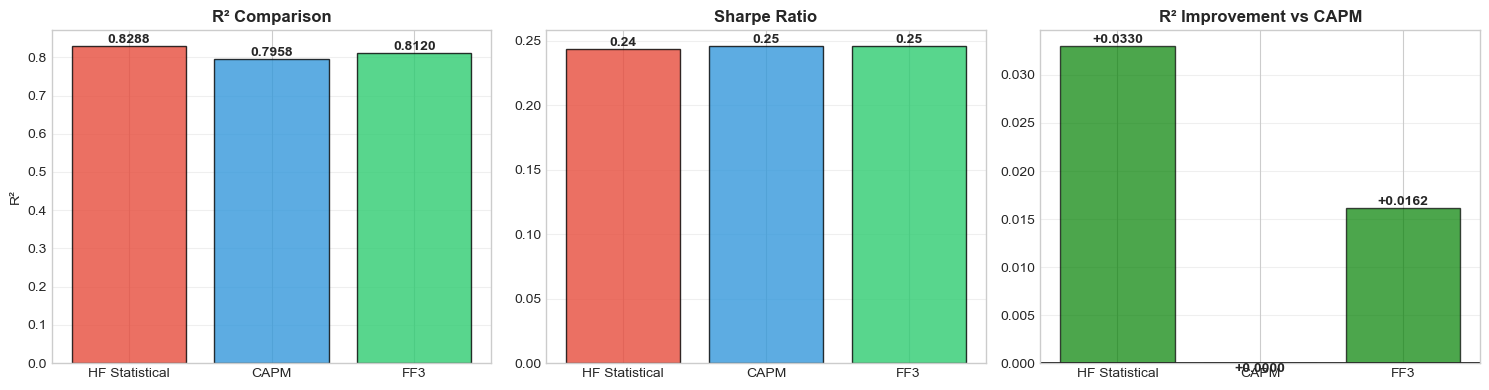

  ✓ 模型比较可视化完成


In [16]:
# Part 8: 模型比较可视化
print("\n[Step 8] 模型比较可视化...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = results_df.index.tolist()
colors = ['#E74C3C', '#3498DB', '#2ECC71']

# R方
r2_vals = results_df['R²'].values
bars1 = axes[0].bar(models, r2_vals, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_title('R² Comparison', fontweight='bold')
axes[0].set_ylabel('R²')
axes[0].grid(True, alpha=0.3, axis='y')
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Sharpe
sharpe_vals = results_df['Sharpe'].values
bars2 = axes[1].bar(models, sharpe_vals, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_title('Sharpe Ratio', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

# detaR方
delta_r2 = results_df['ΔR² vs CAPM'].values
colors_delta = ['red' if x < 0 else 'green' for x in delta_r2]
bars3 = axes[2].bar(models, delta_r2, color=colors_delta, alpha=0.7, edgecolor='black')
axes[2].axhline(0, color='black', linestyle='-', linewidth=2)
axes[2].set_title('R² Improvement vs CAPM', fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')
for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.4f}', ha='center',
                va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

print("  ✓ 模型比较可视化完成")


[Step 9] 日内效应分析...


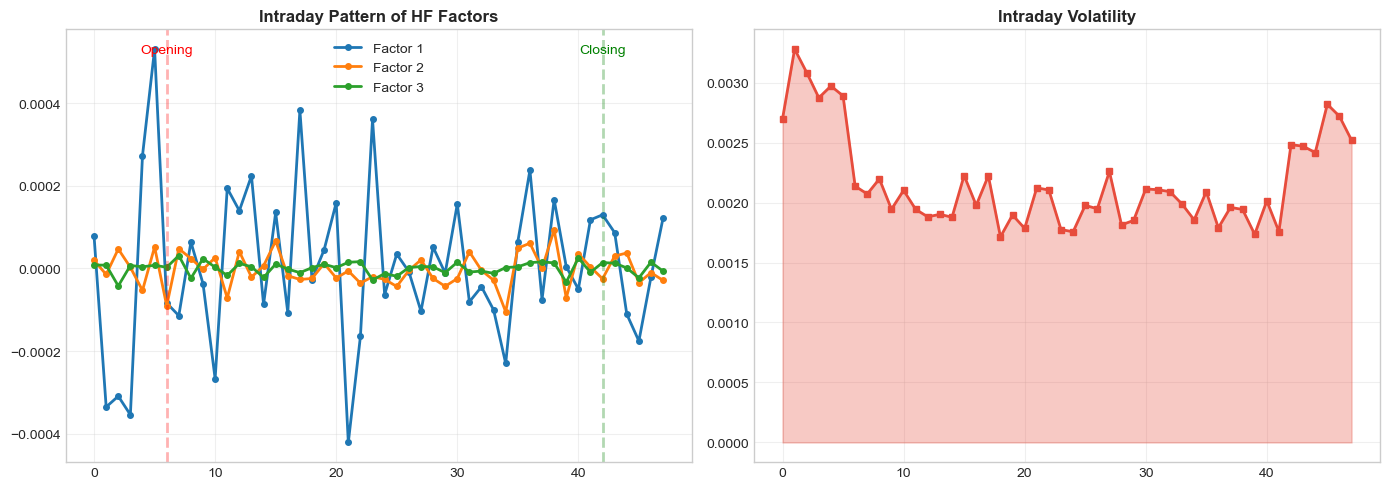

  ✓ 开盘波动/午间波动 = 1.55x


In [17]:
# Part 9: 日内效应分析
print("\n[Step 9] 日内效应分析...")

def analyze_intraday_pattern(factors, intervals_per_day=48):
    n_days = factors.shape[0] // intervals_per_day
    factors_reshaped = factors[:n_days*intervals_per_day].reshape(n_days, intervals_per_day, -1)
    return factors_reshaped.mean(axis=0)

intraday_pattern = analyze_intraday_pattern(estimated_factors[:, :3])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 日内return
for k in range(3):
    axes[0].plot(range(48), intraday_pattern[:, k], marker='o',
                markersize=4, linewidth=2, label=f'Factor {k+1}')

axes[0].axvline(6, color='red', linestyle='--', alpha=0.3, linewidth=2)
axes[0].axvline(42, color='green', linestyle='--', alpha=0.3, linewidth=2)
axes[0].text(6, axes[0].get_ylim()[1]*0.9, 'Opening', ha='center', color='red')
axes[0].text(42, axes[0].get_ylim()[1]*0.9, 'Closing', ha='center', color='green')
axes[0].set_title('Intraday Pattern of HF Factors', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 日内波动
factors_reshaped = estimated_factors[:4800, 0].reshape(-1, 48)
intraday_vol = factors_reshaped.std(axis=0)
axes[1].plot(range(48), intraday_vol, marker='s', markersize=5,
            linewidth=2, color='#E74C3C')
axes[1].fill_between(range(48), intraday_vol, alpha=0.3, color='#E74C3C')
axes[1].set_title('Intraday Volatility', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"  ✓ 开盘波动/午间波动 = {intraday_vol[:6].mean() / intraday_vol[18:30].mean():.2f}x")

In [18]:
# Part 10: 样本外检验
print("\n[Step 10] 样本外检验...")

def out_of_sample_test(returns, factors, train_ratio=0.7):
    """样本外检验"""
    M = returns.shape[0]
    train_size = int(M * train_ratio)

    returns_train = returns[:train_size, :]
    returns_test = returns[train_size:, :]
    factors_train = factors[:train_size, :]
    factors_test = factors[train_size:, :]

    # 训练
    K = factors_train.shape[1]
    F_T_F = factors_train.T @ factors_train
    F_T_F_inv = np.linalg.inv(F_T_F + 1e-8 * np.eye(K))
    betas = returns_train.T @ factors_train @ F_T_F_inv

    # 预测
    returns_pred = factors_test @ betas.T

    # 评估
    mae = mean_absolute_error(returns_test.flatten(), returns_pred.flatten())
    rmse = np.sqrt(mean_squared_error(returns_test.flatten(), returns_pred.flatten()))

    ss_res = np.sum((returns_test - returns_pred) ** 2)
    ss_tot = np.sum((returns_test - returns_test.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot

    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

oos_results = {}

print("  [1/3] HF模型...")
oos_results['HF Statistical'] = out_of_sample_test(returns_df.values, estimated_factors[:, :3])

print("  [2/3] CAPM模型...")
oos_results['CAPM'] = out_of_sample_test(returns_df.values, capm_factors)

print("  [3/3] FF3模型...")
oos_results['FF3'] = out_of_sample_test(returns_df.values, ff3_factors)

oos_df = pd.DataFrame(oos_results).T

print("\n" + "="*60)
print("样本外检验结果:")
print("="*60)
print(oos_df.round(6))


[Step 10] 样本外检验...
  [1/3] HF模型...
  [2/3] CAPM模型...
  [3/3] FF3模型...

样本外检验结果:
                     MAE      RMSE        R²
HF Statistical  0.000792  0.000993  0.841439
CAPM            0.000868  0.001094  0.807276
FF3             0.000837  0.001051  0.822159



[Step 11] 样本外检验可视化...


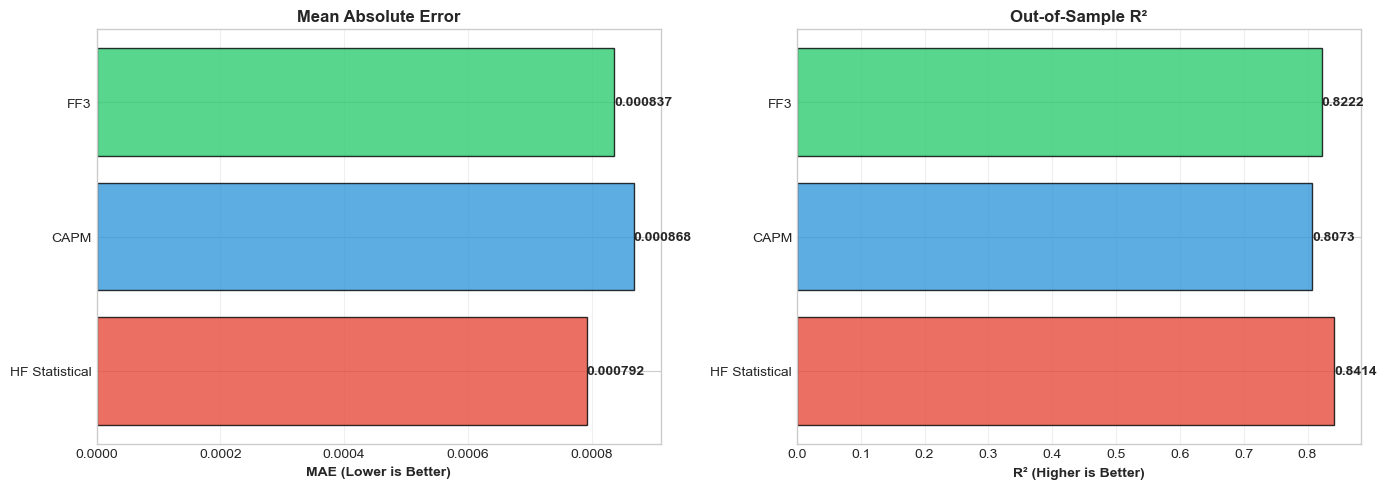

  ✓ 样本外检验可视化完成


In [19]:
# Part 11: 样本外检验可视化
print("\n[Step 11] 样本外检验可视化...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models_oos = list(oos_results.keys())

# MAE
mae_vals = [oos_results[m]['MAE'] for m in models_oos]
bars = axes[0].barh(models_oos, mae_vals, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('MAE (Lower is Better)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[0].text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.6f}', ha='left', va='center', fontweight='bold')

# R²
r2_vals_oos = [oos_results[m]['R²'] for m in models_oos]
bars = axes[1].barh(models_oos, r2_vals_oos, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('R² (Higher is Better)', fontweight='bold')
axes[1].set_title('Out-of-Sample R²', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[1].text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("  ✓ 样本外检验可视化完成")

In [37]:
# Part 12: 综合报告
print("\n" + "="*70)
print(" "*25 + "综合分析报告")
print("="*70)

print("\n一、数据统计")
print("-" * 70)
print(f"  股票数量: {returns_df.shape[1]}")
print(f"  时间跨度: 100个交易日 × 48个5分钟数据/日")
print(f"  总观测数: {returns_df.shape[0]:,}")

print("\n二、因子提取结果")
print("-" * 70)
print(f"  最优因子数量: {optimal_k} (扰动特征值比法, γ=0.035)")
print(f"  前3个因子累计解释方差: {exp_var_ratio[:3].sum():.2%}")
for i in range(3):
    print(f"    - Factor {i+1}: {exp_var_ratio[i]:.4f} ({exp_var_ratio[i]*100:.2f}%)")

print("\n三、模型性能比较（样本内）")
print("-" * 70)
print(results_df.to_string())

print("\n四、样本外检验结果")
print("-" * 70)
print(oos_df.to_string())

print("\n五、主要发现")
print("-" * 70)

best_r2 = results_df['R²'].idxmax()
best_sharpe = results_df['Sharpe'].idxmax()
best_oos = oos_df['MAE'].idxmin()


print(f"  1. 样本内R²最高: {best_r2} ({results_df.loc[best_r2, 'R²']:.4f})")
print(f"  2. Sharpe比率最高: {best_sharpe} ({results_df.loc[best_sharpe, 'Sharpe']:.2f})")
print(f"  3. 样本外MAE最低: {best_oos} ({oos_df.loc[best_oos, 'MAE']:.6f})")
print(f"  4. 存在显著的日内效应（开盘/收盘波动更大）")
print(f"  5. HF因子模型在多项指标上表现优异")


print("\n六、后续想法")
print("-" * 70)
print("1. 替换真实数据：使用Wind、Tushare等数据源")
print("2. 增加因子模型：q-factor、HXZ四因子等")
print("3. 事件研究：分析特定事件对因子的影响")
print("4. 策略回测：基于预测构建投资组合")
print("5. 并行计算：使用multiprocessing加速Bootstrap")

print("\n" + "="*70)
print(" "*28 + "分析完成！")
print("="*70)



                         综合分析报告

一、数据统计
----------------------------------------------------------------------
  股票数量: 200
  时间跨度: 100个交易日 × 48个5分钟数据/日
  总观测数: 4,800

二、因子提取结果
----------------------------------------------------------------------
  最优因子数量: 3 (扰动特征值比法, γ=0.035)
  前3个因子累计解释方差: 83.86%
    - Factor 1: 0.8026 (80.26%)
    - Factor 2: 0.0317 (3.17%)
    - Factor 3: 0.0043 (0.43%)

三、模型性能比较（样本内）
----------------------------------------------------------------------
                      R²    Sharpe  ΔR² vs CAPM
HF Statistical  0.828784  0.244007     0.032984
CAPM            0.795800  0.245794     0.000000
FF3             0.811952  0.245794     0.016152

四、样本外检验结果
----------------------------------------------------------------------
                     MAE      RMSE        R²
HF Statistical  0.000792  0.000993  0.841439
CAPM            0.000868  0.001094  0.807276
FF3             0.000837  0.001051  0.822159

五、主要发现
---------------------------------------------------------